<a href="https://colab.research.google.com/github/vdvran/ICU/blob/master/ICU_Mortality_Prediction_Classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ICU Mortality Prediction Classification


In [0]:
# Import libraries
import numpy as np
import matplotlib
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/PROCESADO MASIVO/pre_ICU_Mortality_Prediction.csv")
'''data =pd.read_csv("pre_ICU_Mortality_Prediction.csv")'''

'data =pd.read_csv("pre_ICU_Mortality_Prediction.csv")'

In [0]:
data=data.drop(['Unnamed: 0'], axis=1)
data.head()

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,0.0,68.0,22.730000,0.0,180.3,0.541667,0.0,73.9,113.0,502.01,0.0,0.0,31.0,2.51,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,36.0,134.0,39.3,0.0,14.1,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,...,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0
1,0.0,77.0,27.420000,0.0,160.0,0.927778,0.0,70.2,108.0,203.01,0.0,0.0,9.0,0.56,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,33.0,145.0,35.1,1.0,12.7,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,...,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
2,0.0,25.0,31.950000,0.0,172.7,0.000694,0.0,95.3,122.0,703.03,0.0,0.0,19.0,0.98,3.0,6.0,0.0,5.0,133.0,102.0,33.2,0.0,68.0,37.0,138.0,36.7,0.0,10.4,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,...,8.4,8.2,1.00,0.95,150.0,107.0,24.0,23.0,11.4,10.9,34.5,33.2,196.0,187.0,4.2,3.9,139.0,138.0,11.0,10.1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0
3,0.0,81.0,22.640000,1.0,165.1,0.000694,0.0,61.7,203.0,1206.03,1.0,0.0,19.0,0.98,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,4.0,138.0,34.8,1.0,8.0,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,...,8.4,8.2,1.00,0.95,185.0,88.0,24.0,23.0,11.6,8.9,34.0,25.9,198.0,43.0,5.0,3.5,139.0,138.0,9.0,8.0,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0
4,0.0,19.0,27.654655,0.0,188.0,0.073611,0.0,80.3,119.0,601.01,0.0,0.0,19.0,0.98,4.0,6.0,0.0,5.0,133.0,60.0,33.2,0.0,103.0,16.0,138.0,36.7,0.0,10.4,99.0,57.0,99.0,57.0,89.0,60.0,104.0,90.0,104.0,90.0,18.0,16.0,...,8.4,8.2,1.00,0.95,150.0,107.0,24.0,23.0,11.4,10.9,34.5,33.2,196.0,187.0,4.2,3.9,139.0,138.0,11.0,10.1,0.05,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0


# Content

**1. General info**

    a) df visualisation (ICU Mortality Prediction Visualization Notebook)
  
    b)  drop variables with a lot of missing values (ICU Mortality Prediction Preprocessing Notebook)
  
  
**2. Remove outliers** (ICU Mortality Prediction Preprocessing Notebook)


**3. Replace missing values** (ICU Mortality Prediction Preprocessing Notebook)


**4. One Hot Encoding** (ICU Mortality Prediction Preprocessing Notebook)


**5. Normalisation** (ICU Mortality Prediction Classification Notebook)

    a) x, y and train_test_split 

    b) Standarisation 

**6. Feature Selection** (ICU Mortality Prediction Classification Notebook)

    a) Feature importance

    b) Algoritmo univariante --> Prueba F de Fisher

    c) Eliminación Recursiva de atributos --> 
 
 **7. Unbalanced** (ICU Mortality Prediction Classification Notebook)
    
    a) Undersampling
 
 **8. Classification** (ICU Mortality Prediction Classification Notebook)
 
    a) LDA (Fisher)
 
    b) Mayoría de votos
 
    c) Boosted trees
   
    d) Random forest
    
 **9.Comparison**(ICU Mortality Prediction Classification Notebook)


---------


# Normalisation

## Train and Test

In [0]:
y = data['hospital_death']
x = data.loc[:, data.columns != 'hospital_death']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [0]:
names = x_train.columns

scaler = preprocessing.StandardScaler()

#x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=names)
df_y = pd.DataFrame(y_train)

-------

# Feature selection

## Feature importance

In [0]:
threshold = 0.9
# Absolute value correlation matrix
corr_matrix = x.corr().abs()
corr_matrix.head()

,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
age,1.000000,0.086472,0.064523,0.109526,0.049163,NaN,0.126515,0.020766,0.056479,0.056585,0.002590,0.206649,0.050835,0.026379,0.025728,0.008018,0.017073,0.010059,0.146543,0.103514,0.013445,0.016354,0.037962,0.033455,0.080080,0.038640,0.005067,0.061188,0.208684,0.058642,0.205758,0.132919,0.140982,0.006183,0.129646,0.005916,0.127668,0.031990,0.035014,0.037621,...,0.020605,0.042886,0.052533,0.069077,0.014577,0.065380,0.057113,0.089361,0.139015,0.131901,0.112127,0.110318,0.071749,0.071535,0.056890,0.103533,0.007121,0.035380,0.000862,0.002252,0.206520,0.120153,0.029680,0.028844,0.074723,0.020665,0.023907,0.029600,0.022796,0.024983,0.155293,0.050252,0.005158,0.286280,0.008042,0.030091,0.024166,0.083385,0.028262,0.027576
bmi,0.086472,1.000000,0.015975,0.052753,0.000160,NaN,0.873599,0.024247,0.006238,0.015509,0.005708,0.042388,0.060039,0.012521,0.020629,0.006683,0.027438,0.096949,0.020018,0.083874,0.037116,0.054000,0.001270,0.018628,0.036824,0.069470,0.026701,0.053654,0.008115,0.054117,0.008137,0.029730,0.016310,0.059243,0.014394,0.059354,0.014534,0.003191,0.010169,0.065528,...,0.059989,0.063681,0.063668,0.065106,0.096901,0.129190,0.086065,0.082707,0.051858,0.055404,0.083511,0.083987,0.017468,0.016886,0.081503,0.086861,0.022868,0.015689,0.023016,0.022133,0.039604,0.018035,0.020016,0.002313,0.168447,0.001742,0.030527,0.013025,0.009658,0.042417,0.038734,0.022638,0.007969,0.048204,0.025929,0.039787,0.018304,0.048079,0.017027,0.031674
elective_surgery,0.064523,0.015975,1.000000,0.023238,0.131843,NaN,0.026468,0.356357,0.775327,0.908247,0.026699,0.136218,0.085463,0.007885,0.014289,0.012606,0.015309,0.020491,0.070327,0.111171,0.162144,0.000846,0.141097,0.042085,0.041102,0.148698,0.080709,0.191544,0.007192,0.183763,0.016912,0.073501,0.025646,0.141571,0.012474,0.149012,0.020476,0.063244,0.172659,0.049921,...,0.068827,0.086170,0.089877,0.091723,0.011429,0.002297,0.009520,0.018411,0.052555,0.109792,0.068628,0.130074,0.048379,0.078518,0.095649,0.034705,0.053828,0.025282,0.098707,0.044203,0.170977,0.142261,0.006115,0.031014,0.003642,0.034242,0.014071,0.017257,0.007969,0.015893,0.066016,0.099491,0.036999,0.133043,0.034251,0.043393,0.069350,0.034419,0.028278,0.398976
height,0.109526,0.052753,0.023238,1.000000,0.008589,NaN,0.386629,0.001860,0.014964,0.024890,0.010206,0.017521,0.052160,0.008761,0.014023,0.001376,0.008716,0.006240,0.024350,0.111927,0.019768,0.033326,0.056281,0.021765,0.014495,0.007248,0.012871,0.033986,0.135869,0.034062,0.136024,0.020519,0.028888,0.021368,0.093006,0.021688,0.093776,0.026163,0.058863,0.023898,...,0.0

In [0]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
x = x.drop(columns = to_drop)

There are 24 columns to remove.


In [0]:
# Train missing values (in percent)
train_missing = (x.isnull().sum() / len(x)).sort_values(ascending = False)
train_missing.head()
train_missing = train_missing.index[train_missing > 0.75]
print('There are %d columns with more than 75%% missing values' % len(train_missing))
x = x.drop(columns = train_missing)

There are 0 columns with more than 75% missing values


In [0]:
feature_importances = np.zeros(x.shape[1])

In [0]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [0]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(x, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)],eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	valid_0's auc: 0.893248	valid_0's binary_logloss: 0.360308
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.887326	valid_0's binary_logloss: 0.322096
Early stopping, best iteration is:
[132]	valid_0's auc: 0.888209	valid_0's binary_logloss: 0.348078


In [0]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
66,apache_4a_hospital_death_prob,197.5
29,d1_heartrate_min,118.0
0,age,97.0
35,d1_spo2_min,97.0
25,wbc_apache,94.0


In [0]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()
# Drop features with zero importance
x = x.drop(columns = zero_features)

There are 6 features with 0.0 importance


In [0]:
def plot_feature_importances(df, threshold = 0.9):
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
     # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    return df

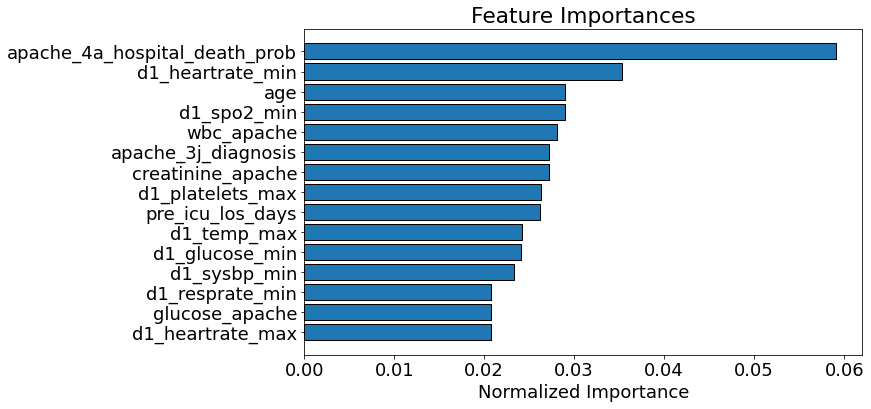

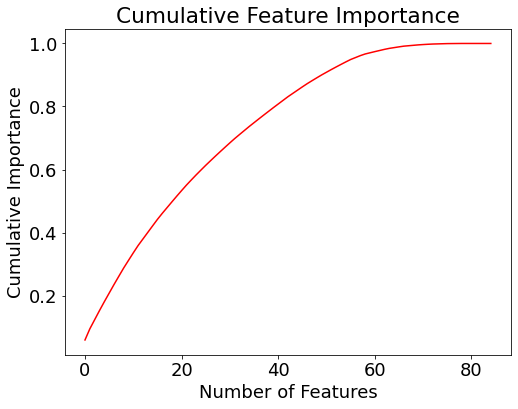

50 features required for 0.90 of cumulative importance


In [0]:
norm_feature_importances = plot_feature_importances(feature_importances)

## Prueba F de Fisher

In [0]:
# Aplicando el algoritmo univariante de prueba F.
k = 50  # número de atributos a seleccionar
entrenar = data.drop(['hospital_death'], axis=1)
columnas = list(entrenar.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(entrenar, y)

atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning:

Features [5] are constant.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning:

invalid value encountered in true_divide



## Eliminación Recursiva de atributos

In [0]:
modelo = ExtraTreesClassifier()
era = RFE(modelo, 52)  # número de atributos a seleccionar
era = era.fit(entrenar, y)

atrib = era.support_
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]

-------

# Unbalanced

## Undersumpling

In [0]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [0]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
x_rus, y_rus, id_rus = rus.fit_sample(x_train, y_train)

print('Removed indexes:', id_rus)


Removed indexes: [42274 60035 51018 ... 73347 73356 73368]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



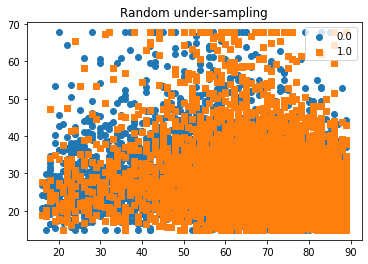

(12636, 12636)

In [0]:
plot_2d_space(x_rus, y_rus, 'Random under-sampling')
len(x_rus),len(y_rus)


## Oversampling

In [0]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x_ros, y_ros = ros.fit_sample(x_train, y_train)

print(x_ros.shape[0] - x_train.shape[0], 'new random picked points')



60734 new random picked points


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



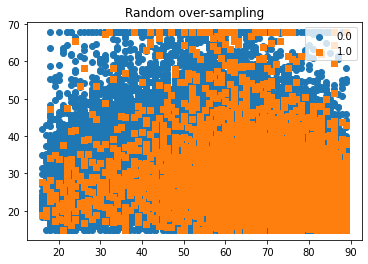

(134104, 134104)

In [0]:
plot_2d_space(x_ros, y_ros, 'Random over-sampling')
len(x_ros),len(y_ros)

-------

# Classification

In [0]:
def matriz_confusion(cnf):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## LDA (Fisher)

#### 1. Unbalanced data

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [0]:
kf = KFold(n_splits=5)
clf_fda = LinearDiscriminantAnalysis(n_components=2)
clf_fda.fit(x_train, y_train)
score = clf_fda.score(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning:

n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(109, 2 - 1) = 1 components.

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning:

In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).



In [0]:
from sklearn import metrics
y_pred = clf_fda.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_f=metrics.recall_score(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9189881698740664
[[16208   538]
 [  948   649]]


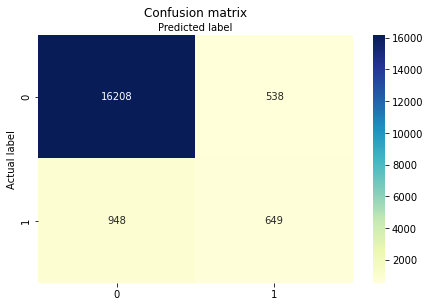

In [0]:
matriz_confusion(cnf_matrix)

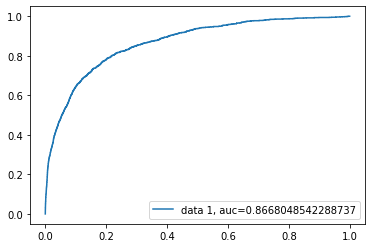

In [0]:
y_pred_proba = clf_fda.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_f = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_f))
plt.legend(loc=4)
plt.show()

#### 2. Balanced data

Undersampling

In [0]:
kf = KFold(n_splits=5)
clf_fda = LinearDiscriminantAnalysis(n_components=2)
clf_fda.fit(x_rus, y_rus)
score = clf_fda.score(x_rus,y_rus)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning:

n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(109, 2 - 1) = 1 components.

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning:

In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).



In [0]:
from sklearn import metrics
y_pred = clf_fda.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_fu=metrics.recall_score(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.8137709207872212
[[13705  3041]
 [  375  1222]]


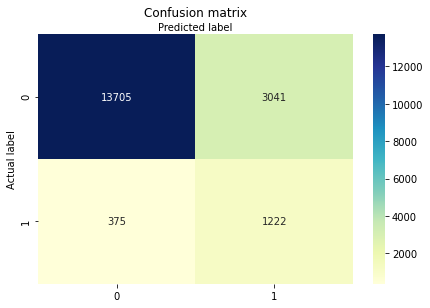

In [0]:
matriz_confusion(cnf_matrix)

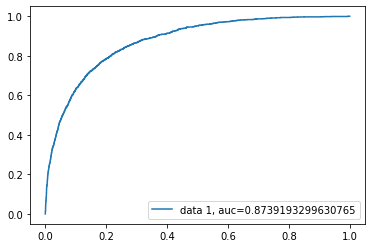

In [0]:
y_pred_proba = clf_fda.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_fu = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_fu))
plt.legend(loc=4)
plt.show()

Oversampling

In [0]:
clf_fda = LinearDiscriminantAnalysis(n_components=2)
clf_fda.fit(x_ros, y_ros)
score = clf_fda.score(x_ros,y_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning:

n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(109, 2 - 1) = 1 components.

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning:

In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).



In [0]:
from sklearn import metrics
y_pred = clf_fda.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_fo=metrics.recall_score(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.8152428719402497
[[13727  3019]
 [  370  1227]]


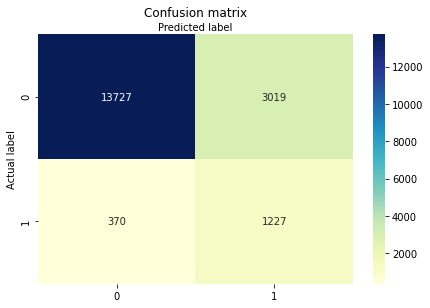

In [0]:
matriz_confusion(cnf_matrix)

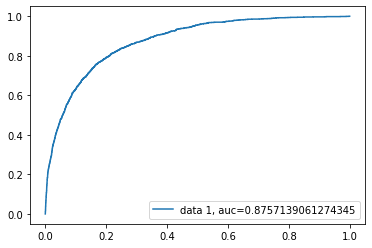

In [0]:
y_pred_proba = clf_fda.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_fo = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_fo))
plt.legend(loc=4)
plt.show()

## Mayoría de votos

#### 1. Unbalanced

In [0]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier
# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=100)
# Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=1)
# Voting Classifier with soft voting 
votingC = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
votingC = votingC.fit(x_train, y_train)
y_pred = votingC.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_m=metrics.recall_score(y_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy: 0.9292918279452652
[[16564   182]
 [ 1115   482]]


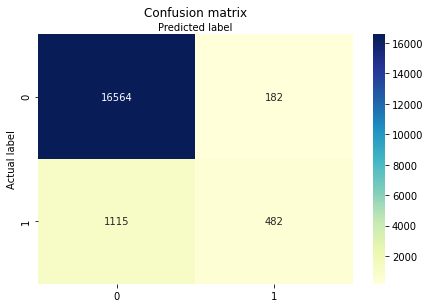

In [0]:
matriz_confusion(cnf_matrix)

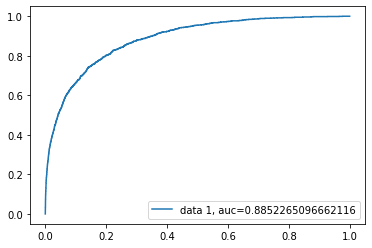

In [0]:
y_pred_proba = votingC.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_m = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_m))
plt.legend(loc=4)
plt.show()

#### 2. Balanced 

Undersampling

In [0]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier
# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=100)
# Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=1)
# Voting Classifier with soft voting 
votingC = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
votingC = votingC.fit(x_rus, y_rus)
y_pred = votingC.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_mu=metrics.recall_score(y_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy: 0.8015591778880227
[[13418  3328]
 [  312  1285]]


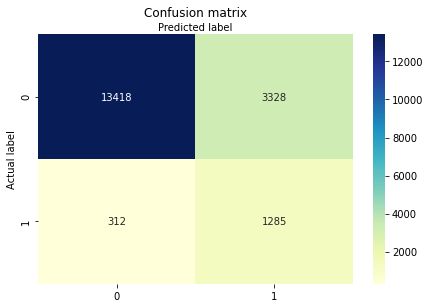

In [0]:
matriz_confusion(cnf_matrix)

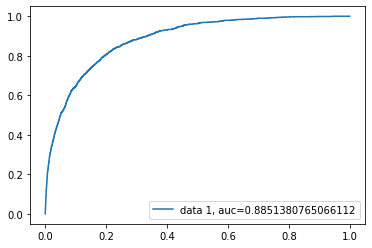

In [0]:
y_pred_proba = votingC.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_mu = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_mu))
plt.legend(loc=4)
plt.show()

Oversampling

In [0]:
# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=100)
# Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=1)
# Voting Classifier with soft voting 
votingC = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
votingC = votingC.fit(x_ros, y_ros)
y_pred = votingC.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_mo=metrics.recall_score(y_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy: 0.8953279180068691
[[15474  1272]
 [  648   949]]


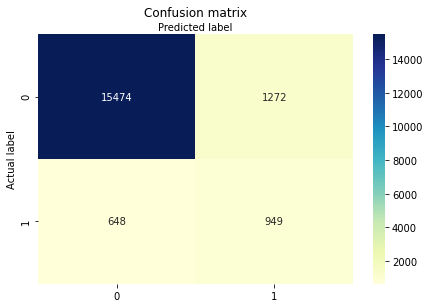

In [0]:
matriz_confusion(cnf_matrix)

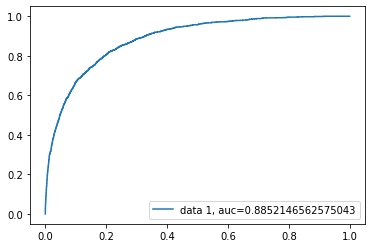

In [0]:
y_pred_proba = votingC.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_mo = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_mo))
plt.legend(loc=4)
plt.show()

## Boosted Trees

#### 1. Unbalanced

In [0]:
clf = GBC.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_b=metrics.recall_score(y_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy: 0.9284195605953225
[[16529   217]
 [ 1096   501]]


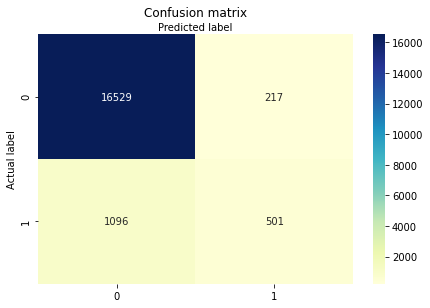

In [0]:
matriz_confusion(cnf_matrix)

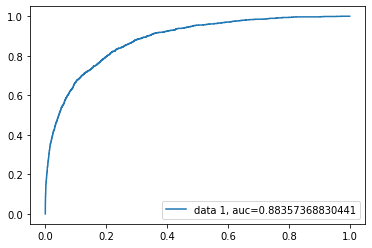

In [0]:
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_b = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_b))
plt.legend(loc=4)
plt.show()

#### 2. Balanced

Undersampling

In [0]:
clf = GBC.fit(x_rus, y_rus)
y_pred = clf.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_bu=metrics.recall_score(y_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy: 0.802376928528594
[[13450  3296]
 [  329  1268]]


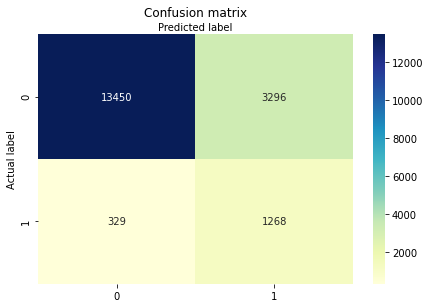

In [0]:
matriz_confusion(cnf_matrix)

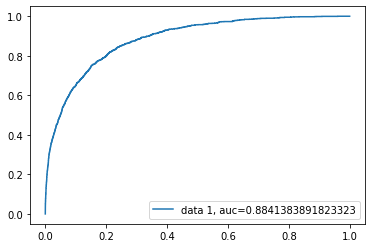

In [0]:
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_bu = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_bu))
plt.legend(loc=4)
plt.show()

Oversampling

In [0]:
clf = GBC.fit(x_ros, y_ros)
y_pred = clf.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_bo=metrics.recall_score(y_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy: 0.810772501771793
[[13617  3129]
 [  342  1255]]


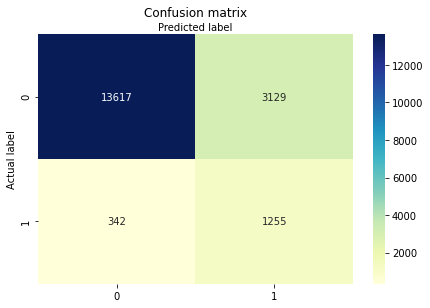

In [0]:
matriz_confusion(cnf_matrix)

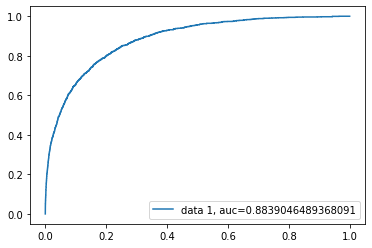

In [0]:
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_bo = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_bo))
plt.legend(loc=4)
plt.show()

## Random Forest

#### 1. Unbalanced

In [0]:
clf = RFC.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_r=metrics.recall_score(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9274382598266369
[[16572   174]
 [ 1157   440]]


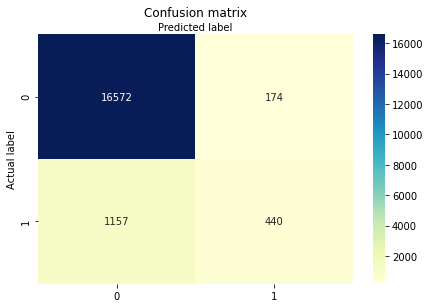

In [0]:
matriz_confusion(cnf_matrix)

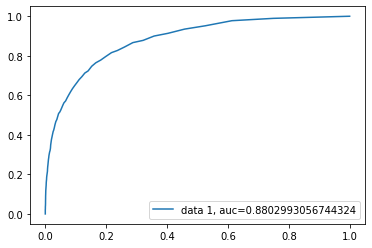

In [0]:
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_r = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_r))
plt.legend(loc=4)
plt.show()

#### 2. Balanced

Undersampling

In [0]:
clf = RFC.fit(x_rus, y_rus)
y_pred = clf.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_ru=metrics.recall_score(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.7980701084882517
[[13343  3403]
 [  301  1296]]


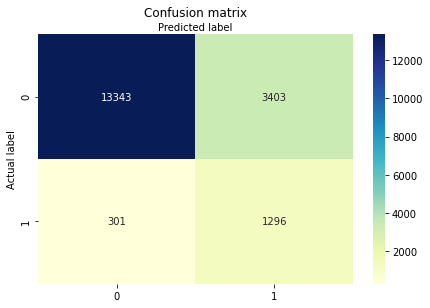

In [0]:
matriz_confusion(cnf_matrix)

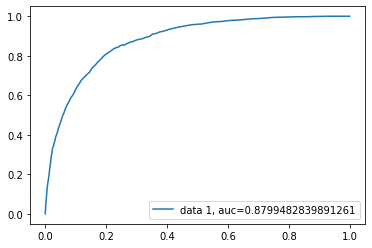

In [0]:
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_ru = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_ru))
plt.legend(loc=4)
plt.show()

Oversampling

In [0]:
clf = RFC.fit(x_ros, y_ros)
y_pred = clf.predict(x_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sen_ro=metrics.recall_score(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9244943575205801
[[16503   243]
 [ 1142   455]]


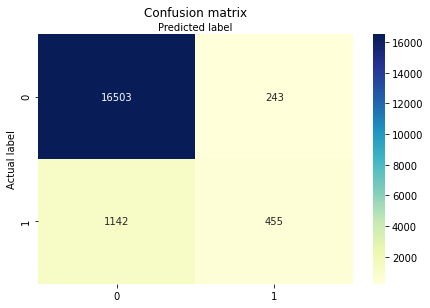

In [0]:
matriz_confusion(cnf_matrix)

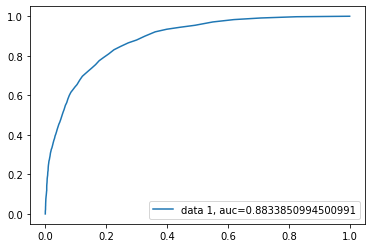

In [0]:
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_ro = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_ro))
plt.legend(loc=4)
plt.show()

## SVM (support vector machine)

## Umbalanced


In [0]:
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size=0.98, random_state=1)

In [0]:
x_train_sub.describe()

,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
count,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.0,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,...,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.0,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,62.401500,28.816941,0.172461,169.963572,0.658042,0.0,83.451541,187.127471,551.239646,0.190866,0.023858,24.222904,1.361594,3.453988,5.431493,0.008180,4.011588,158.874301,100.190866,33.076687,0.141786,89.203817,26.105590,137.907157,36.435058,0.318337,11.654533,88.995910,50.528289,89.121336,50.605999,103.119291,70.286299,105.064758,65.576005,104.973415,65.524881,28.644172,12.948875,99.274029,...,8.372393,8.181868,1.401353,1.293801,174.783231,114.483299,24.298432,23.202454,11.478187,10.929448,34.656578,33.065372,202.485344,192.892331,4.253920,3.942679,138.991138,137.746285,12.195331,11.042361,0.111391,0.067498,0.0,0.016360,0.232447,0.007498,0.023177,0.004772,0.002045,0.023177,0.447853,0.100204,0.006135,0.086571,0.137696,0.032720,0.107021,0.044990,0.003408,0.033401
std,16.622945,8.127165,0.377909,10.505275,1.764834,0.0,24.639257,86.204194,458.769701,0.393117,0.152659,18.256153,1.349774,0.972909,1.336308,0.090103,1.550162,88.100810,31.750311,6.077554,0.348949,42.404825,14.847259,4.658150,0.783627,0.465990,6.156516,20.248221,13.144220,20.171035,13.107236,22.589977,17.408850,21.425477,15.343059,21.350770,15.213215,10.973559,4.844595,1.351024,...,0.696734,0.742602,1.369261,1.235970,87.989438,37.489301,3.945248,4.536128,2.019344,2.233316,5.846798,6.522514,81.480128,81.127964,0.630503,0.551027,4.434831,4.574680,6.522432,5.610737,0.161317,0.128127,0.0,0.126899,0.422537,0.086297,0.150515,0.068936,0.045191,0.150515,0.497443,0.300375,0.078112,0.281302,0.344698,0.177963,0.309246,0.207352,0.058301,0.179744
min,17.000000,14.844926,0.000000,140.000000,0.000000,0.0,38.600000,101.

### Lineal

#### C=1000

In [0]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1000)
model.fit(x_train_sub, y_train_sub)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = model.predict(x_test_sub)

In [0]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_sub, y_pred)
sen_svm_1000=metrics.recall_score(y_test_sub, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test_sub,y_pred))
print("Recall:",sen_svm_1000)
print(cnf_matrix)

Accuracy: 0.9011445975828547
Recall: 0.32591876208897486
[[62773  2926]
 [ 4182  2022]]


In [0]:
#clf = model.fit(x_train_sub, y_train_sub)
#y_pred_proba = clf.predict_proba(x_test_sub)[::,1]
#fpr, tpr, _ = metrics.roc_curve(y_test_sub,  y_pred_proba)
#auc = metrics.roc_auc_score(y_test_sub, y_pred_proba)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
#plt.legend(loc=4)
#plt.show()

#### C=100


In [0]:
model = SVC(kernel='linear', C=100)
model.fit(x_train_sub, y_train_sub)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = model.predict(x_test_sub)

In [0]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_sub, y_pred)
sen_svm_100=metrics.recall_score(y_test_sub, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test_sub,y_pred))
print("Recall:",sen_svm_100)
print(cnf_matrix)

Accuracy: 0.901033336578446
Recall: 0.33752417794970985
[[62693  3006]
 [ 4110  2094]]


#### C=10

In [0]:
model = SVC(kernel='linear', C=10)
model.fit(x_train_sub, y_train_sub)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = model.predict(x_test_sub)

In [0]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_sub, y_pred)
sen_svm_10=metrics.recall_score(y_test_sub, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test_sub,y_pred))
print("Recall:",sen_svm_10)
print(cnf_matrix)

Accuracy: 0.9063599571645133
Recall: 0.32269503546099293
[[63168  2531]
 [ 4202  2002]]


### Lineal - Comparación

In [0]:
import math
import matplotlib
import numpy as np
import sklearn

matplotlib.__version__,np.__version__,sklearn.__version__

('3.2.1', '1.18.2', '0.22.2.post1')

In [0]:
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [0]:
pipeline = Pipeline([
    ('prep',MinMaxScaler()),
    ('clf',SVC())
])

In [0]:
param_grid1 = [
    {
        'clf__kernel': ['linear'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__gamma':['auto']
    }
]

<Figure size 432x288 with 0 Axes>

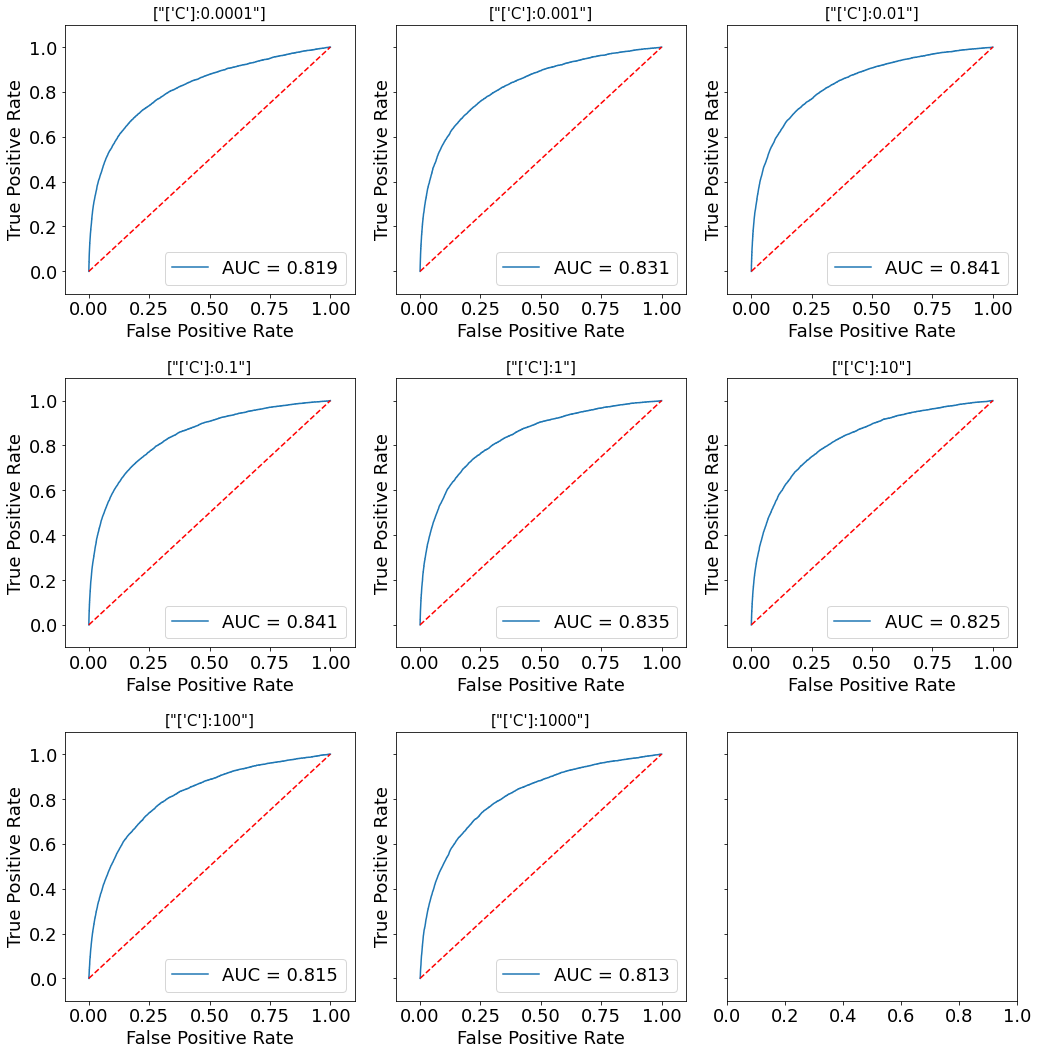

CPU times: user 33 s, sys: 114 ms, total: 33.2 s
Wall time: 33.1 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid1)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid1)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)
    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

### No lineal - Comparación

#### Grado 2

In [0]:
param_grid2 = [
    {
        'clf__kernel': ['poly'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__degree':[2],
        'clf__gamma':['auto']
    }
]

<Figure size 432x288 with 0 Axes>

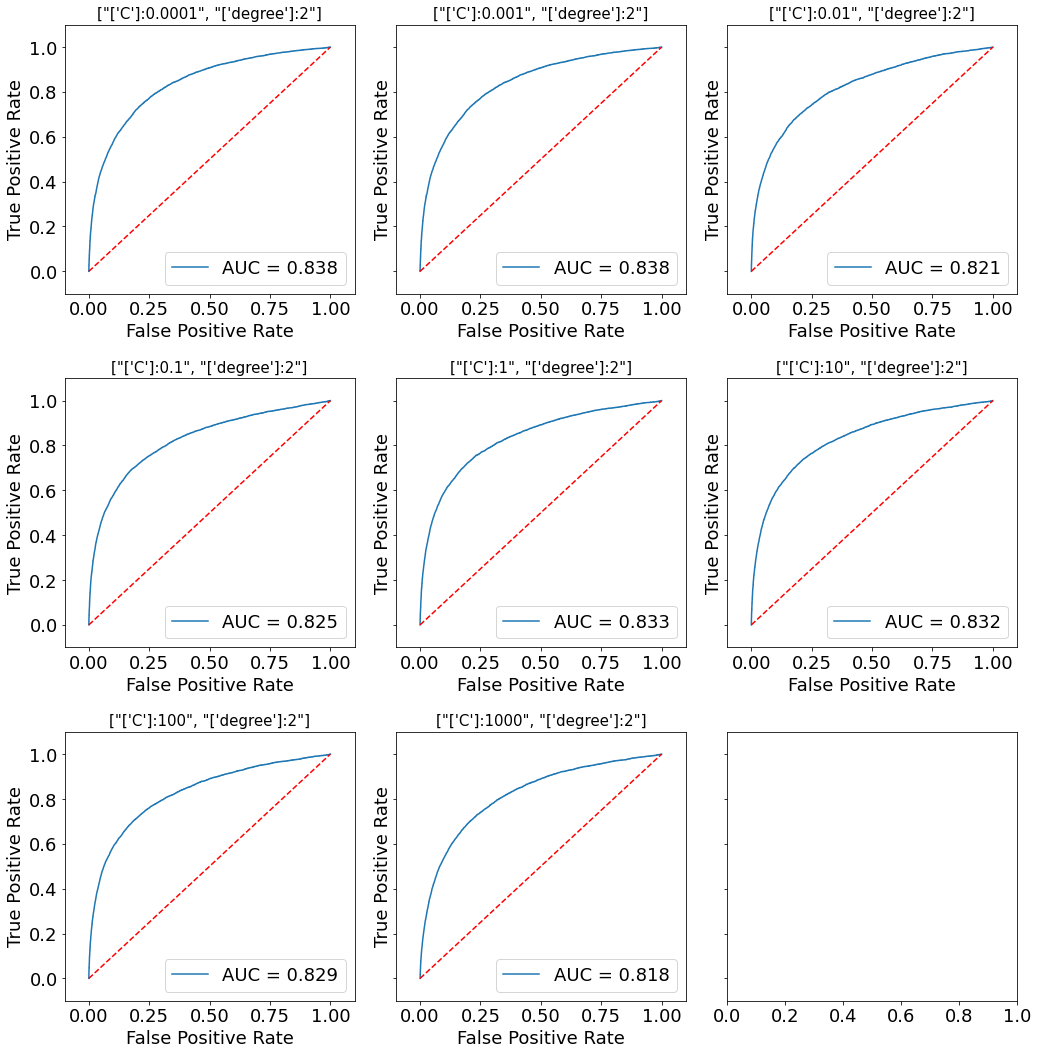

CPU times: user 24 s, sys: 123 ms, total: 24.1 s
Wall time: 24 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid2)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid2)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)

    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

#### Grado 3

In [0]:
param_grid3 = [
    {
        'clf__kernel': ['poly'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__degree':[3],
        'clf__gamma':['auto']
    }
]

<Figure size 432x288 with 0 Axes>

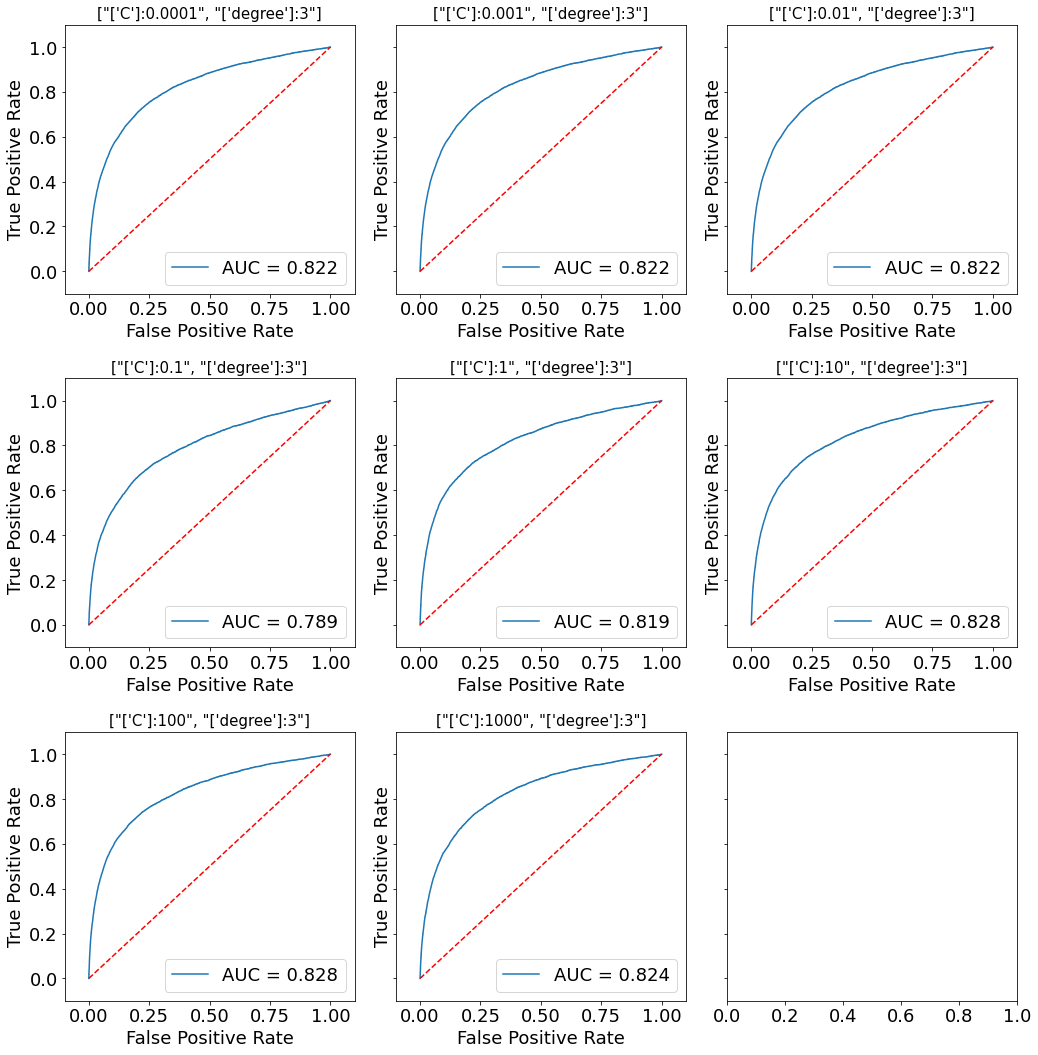

CPU times: user 24.1 s, sys: 114 ms, total: 24.2 s
Wall time: 24.1 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid3)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid3)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)

    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

#### Polinomico

In [0]:
param_grid4 = [
    {
        'clf__kernel': ['poly'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__degree':[2,3,4,5],
        'clf__gamma':['auto']
    }
]

<Figure size 432x288 with 0 Axes>

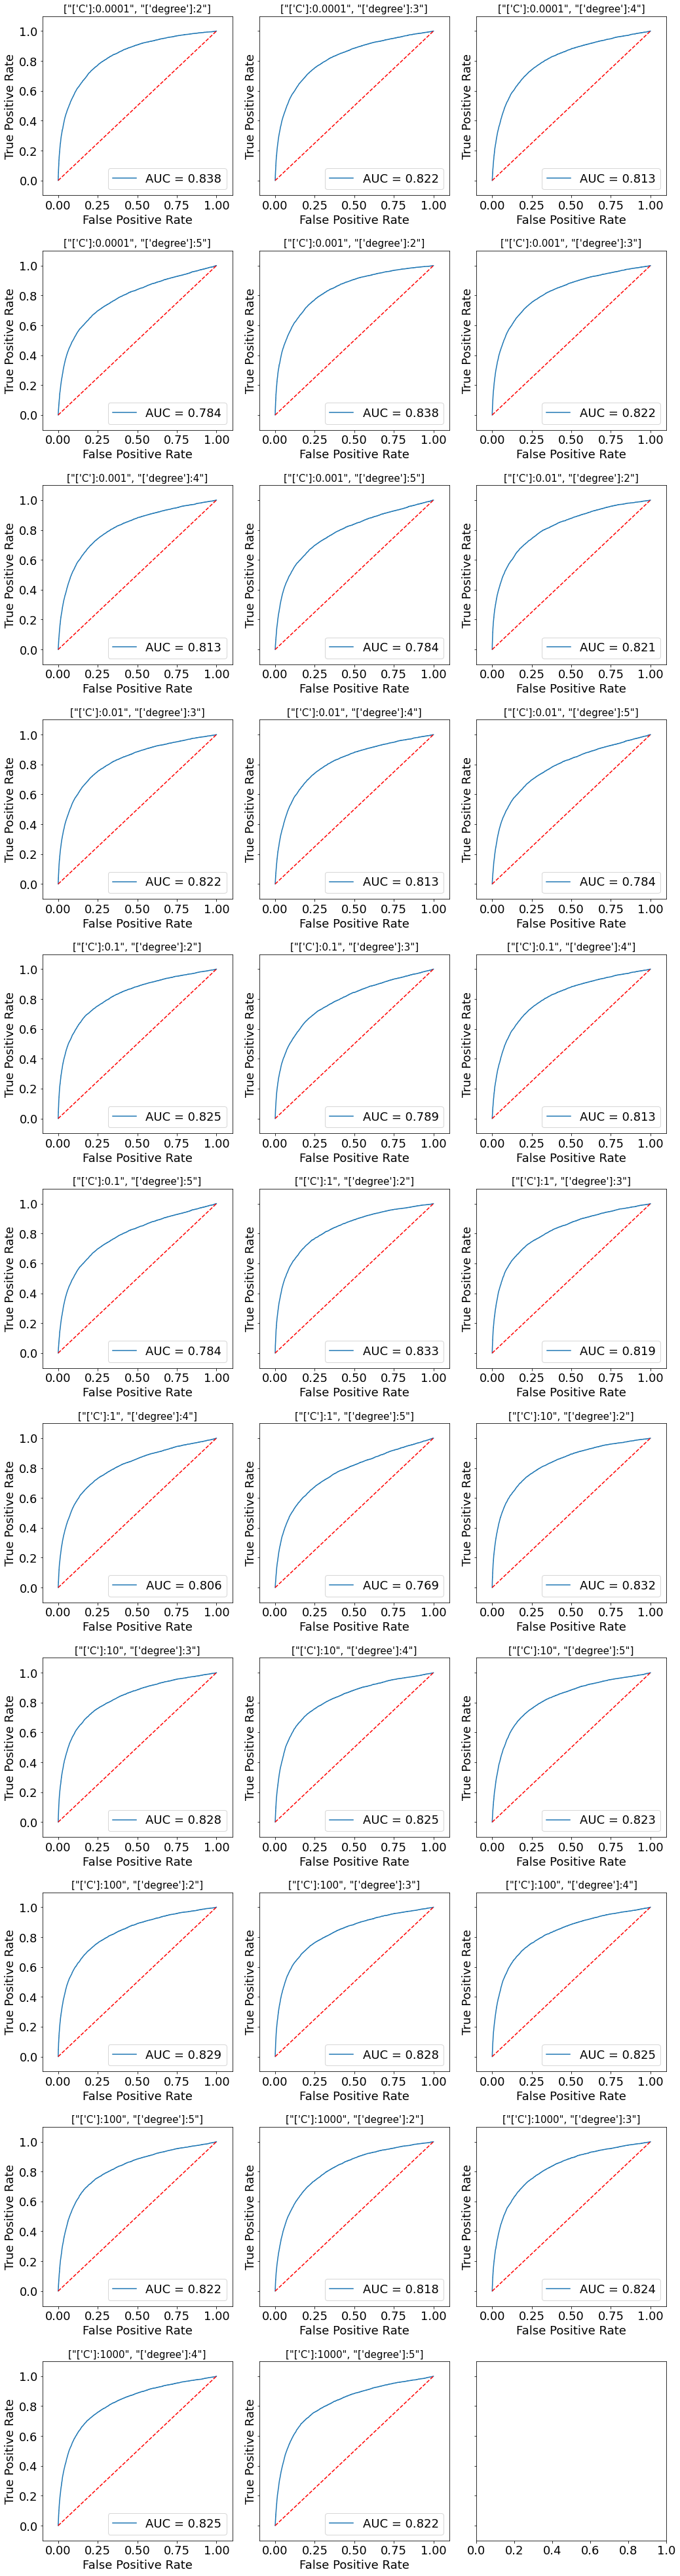

CPU times: user 1min 35s, sys: 248 ms, total: 1min 36s
Wall time: 1min 36s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid4)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid4)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)

    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

#### RBF

In [0]:
param_grid6 = [
    {
        'clf__kernel': ['rbf'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__gamma':['auto']
    }
]

<Figure size 432x288 with 0 Axes>

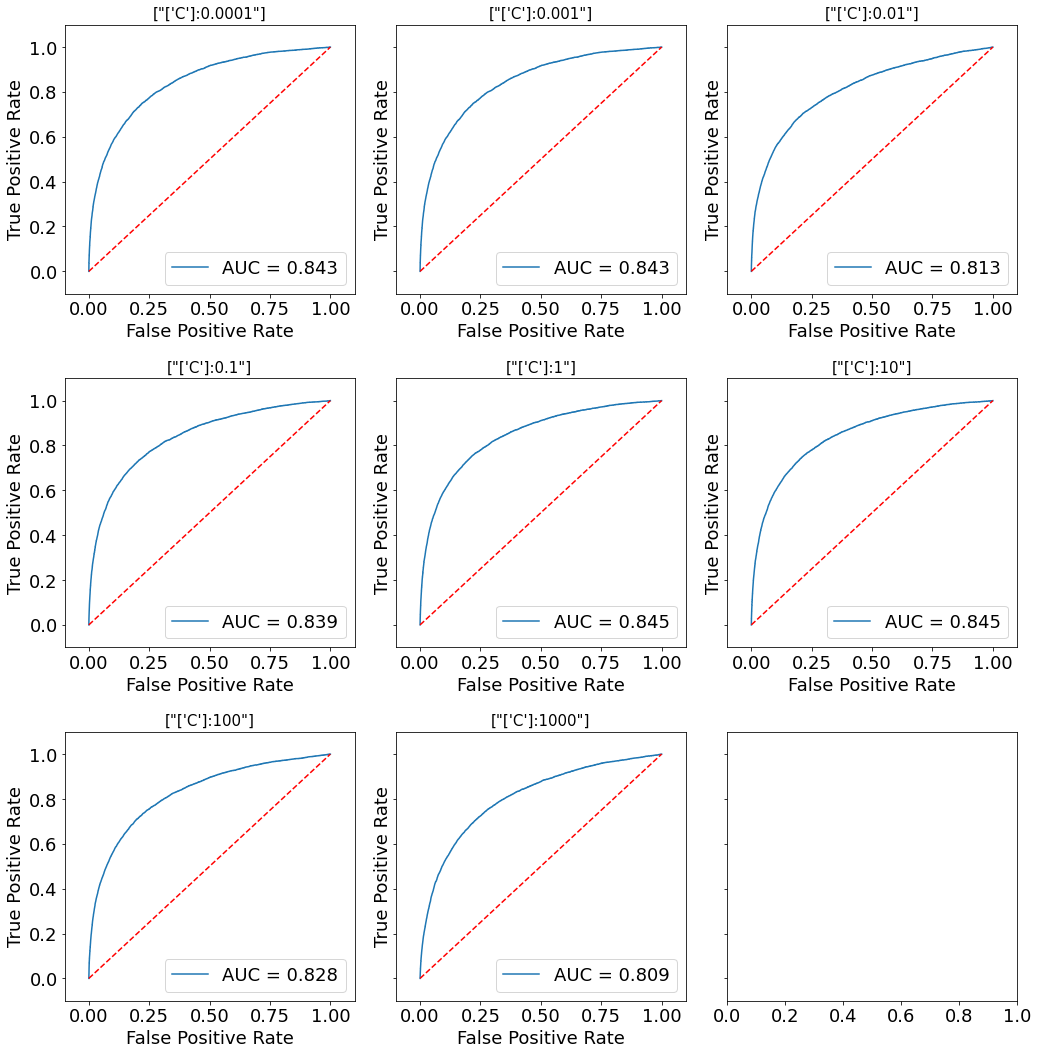

CPU times: user 30.8 s, sys: 116 ms, total: 30.9 s
Wall time: 30.9 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid6)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid6)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)

    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    print('For parameters', g ,' sensibility is: ',sen)


plt.gcf().tight_layout()
plt.show()

### Parametros libres


In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train_sub, y_train_sub)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_sub, clf.predict(x_test_sub)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.461 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.461 (+/-0.001) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.714 (+/-0.106) for {'C': 1, 'kernel': 'linear'}
0.684 (+/-0.083) for {'C': 10, 'kernel': 'linear'}
0.665 (+/-0.087) for {'C': 100, 'kernel': 'linear'}
0.683 (+/-0.066) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    

### No lineal

In [0]:
svm_nolineal = SVC(kernel='poly', degree=8, C=1000)
svm_nolineal.fit(x_train_sub, y_train_sub)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = svm_nolineal.predict(x_test_sub)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print("Accuracy:",metrics.accuracy_score(y_test_sub,y_pred))
print(confusion_matrix(y_test_sub, y_pred))
print(classification_report(y_test_sub, y_pred))

Accuracy: 0.8698107172162497
[[61170  4529]
 [ 4832  1372]]
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     65699
         1.0       0.23      0.22      0.23      6204

    accuracy                           0.87     71903
   macro avg       0.58      0.58      0.58     71903
weighted avg       0.87      0.87      0.87     71903



In [0]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear') # Linear Kernel

In [0]:
svm_clf.fit(x_train_sub, y_train_sub)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = svm_clf.predict(x_test_sub)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test_sub, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test_sub,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.909711694922326
[[63509  2190]
 [ 4302  1902]]


In [0]:
#y_pred_proba = clf.predict_proba(x_test_sub)[::,1]
#fpr, tpr, _ = metrics.roc_curve(y_test_sub,  y_pred_proba)
#auc = metrics.roc_auc_score(y_test_sub, y_pred_proba)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
#plt.legend(loc=4)
#plt.show()

## Balanced

In [0]:
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_rus, y_rus, test_size=0.98, random_state=1)

## Lineal Comparison

In [0]:
pipeline = Pipeline([
    ('prep',MinMaxScaler()),
    ('clf',SVC())
])

param_grid1 = [
    {
        'clf__kernel': ['linear'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__gamma':['auto']
    }
]

For parameters {'clf__C': 0.0001, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.0
For parameters {'clf__C': 0.01, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.5115303983228512
For parameters {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.6337687469762942
For parameters {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.6789227543944525
For parameters {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.7063376874697629
For parameters {'clf__C': 100, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.7069827447185938
For parameters {'clf__C': 1000, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}  sensibility is:  0.6958555071762619


<Figure size 432x288 with 0 Axes>

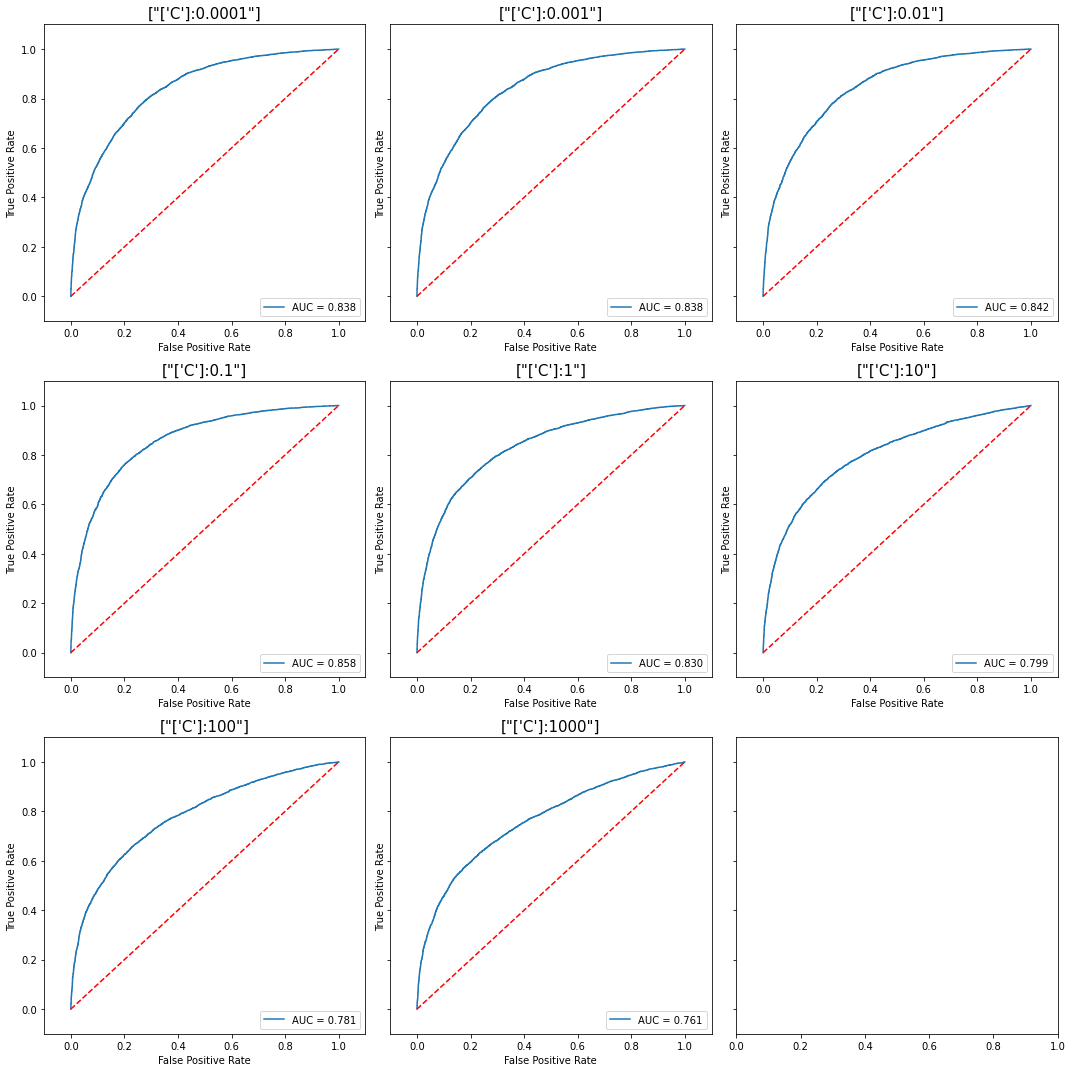

CPU times: user 6.28 s, sys: 115 ms, total: 6.4 s
Wall time: 6.3 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid1)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid1)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)
    sen=metrics.recall_score(y_test_sub, y_pred)
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)

    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

## No lineal Comparison

### Grado 2

In [0]:
param_grid2 = [
    {
        'clf__kernel': ['poly'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__degree':[2],
        'clf__gamma':['auto']
    }
]

For parameters {'clf__C': 0.0001, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.01, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 1, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0016126431220770843
For parameters {'clf__C': 10, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.6329624254152556
For parameters {'clf__C': 100, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.6998871149814546
For parameters {'clf__C': 1000, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.6837606837606838


<Figure size 432x288 with 0 Axes>

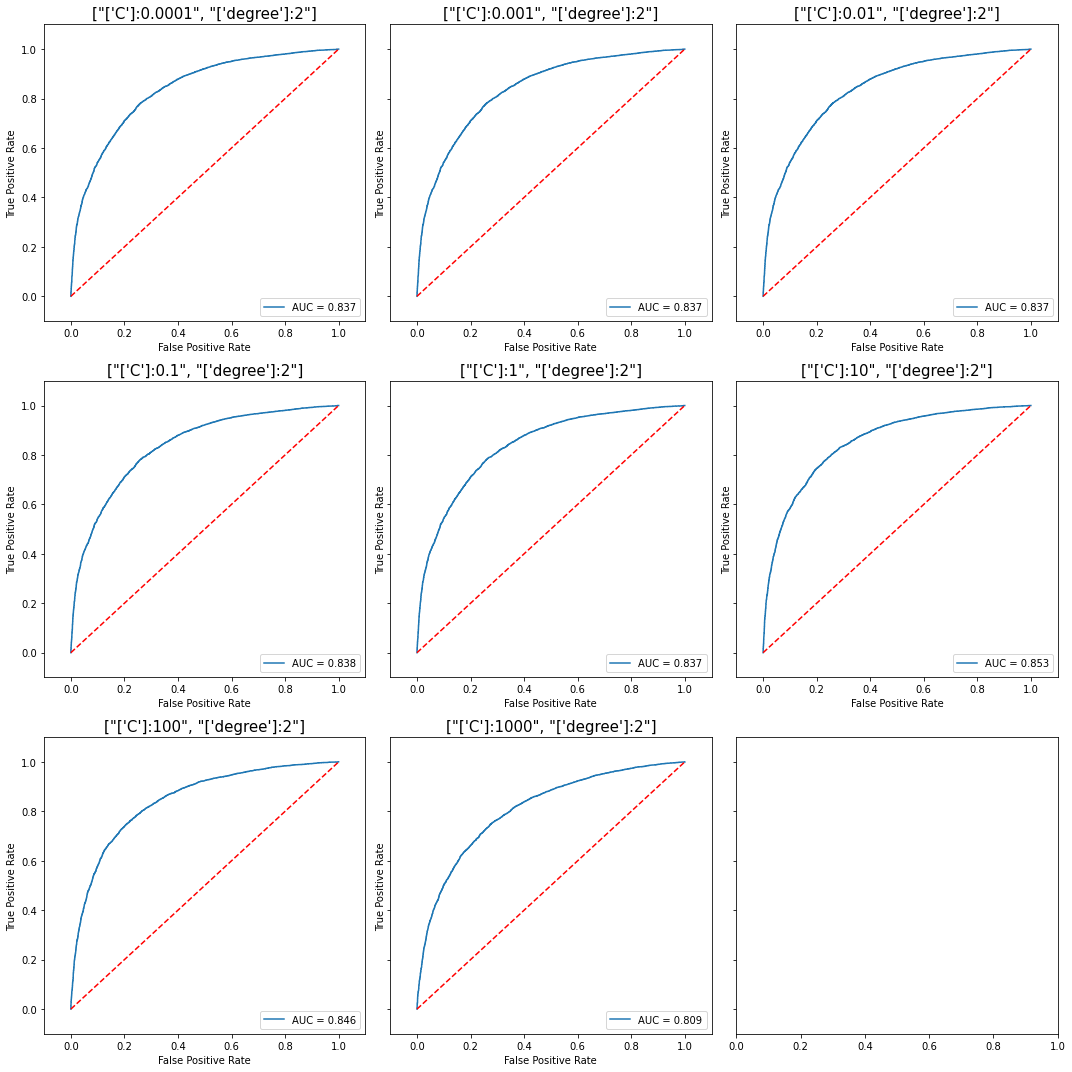

CPU times: user 7.48 s, sys: 115 ms, total: 7.6 s
Wall time: 7.49 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid2)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid2)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)

    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

### Grado 3

In [0]:
param_grid3 = [
    {
        'clf__kernel': ['poly'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__degree':[3],
        'clf__gamma':['auto']
    }
]

For parameters {'clf__C': 0.0001, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.01, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 1, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0016126431220770843
For parameters {'clf__C': 10, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.6329624254152556
For parameters {'clf__C': 100, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.6998871149814546
For parameters {'clf__C': 1000, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.6837606837606838


<Figure size 432x288 with 0 Axes>

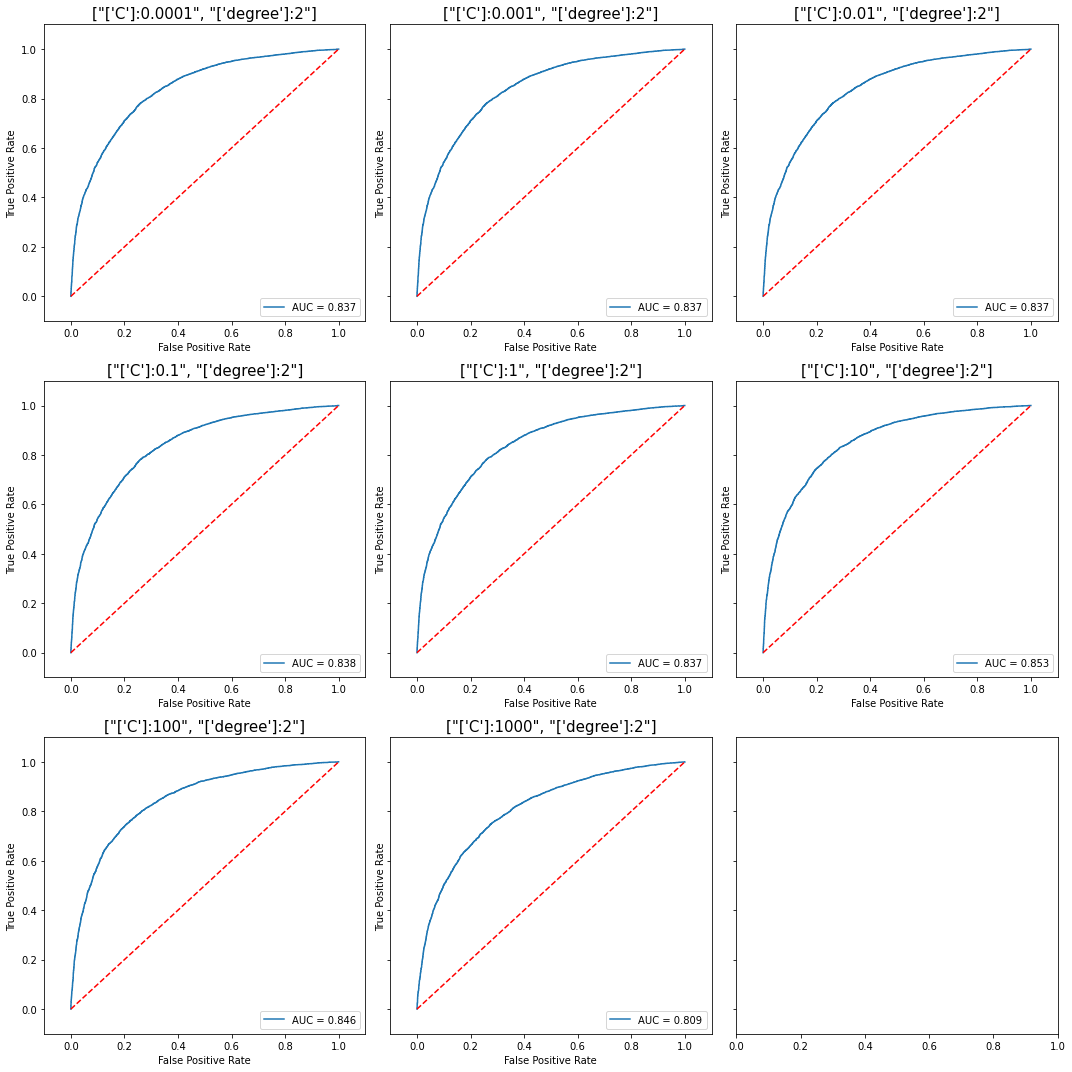

CPU times: user 7.62 s, sys: 120 ms, total: 7.74 s
Wall time: 7.62 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid2)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid2)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)

    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

## Polinomico

In [0]:
param_grid4 = [
    {
        'clf__kernel': ['poly'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__degree':[2,3,4,5],
        'clf__gamma':['auto']
    }
]

For parameters {'clf__C': 0.0001, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.0001, 'clf__degree': 3, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.0001, 'clf__degree': 4, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.0001, 'clf__degree': 5, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__degree': 3, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__degree': 4, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__degree': 5, 'clf__gamma': 'auto', 'clf__kernel': 'poly'}  sensibility is:  0.0
For parameters {'clf__C': 0.01, 'clf__degree': 2, 'c

<Figure size 432x288 with 0 Axes>

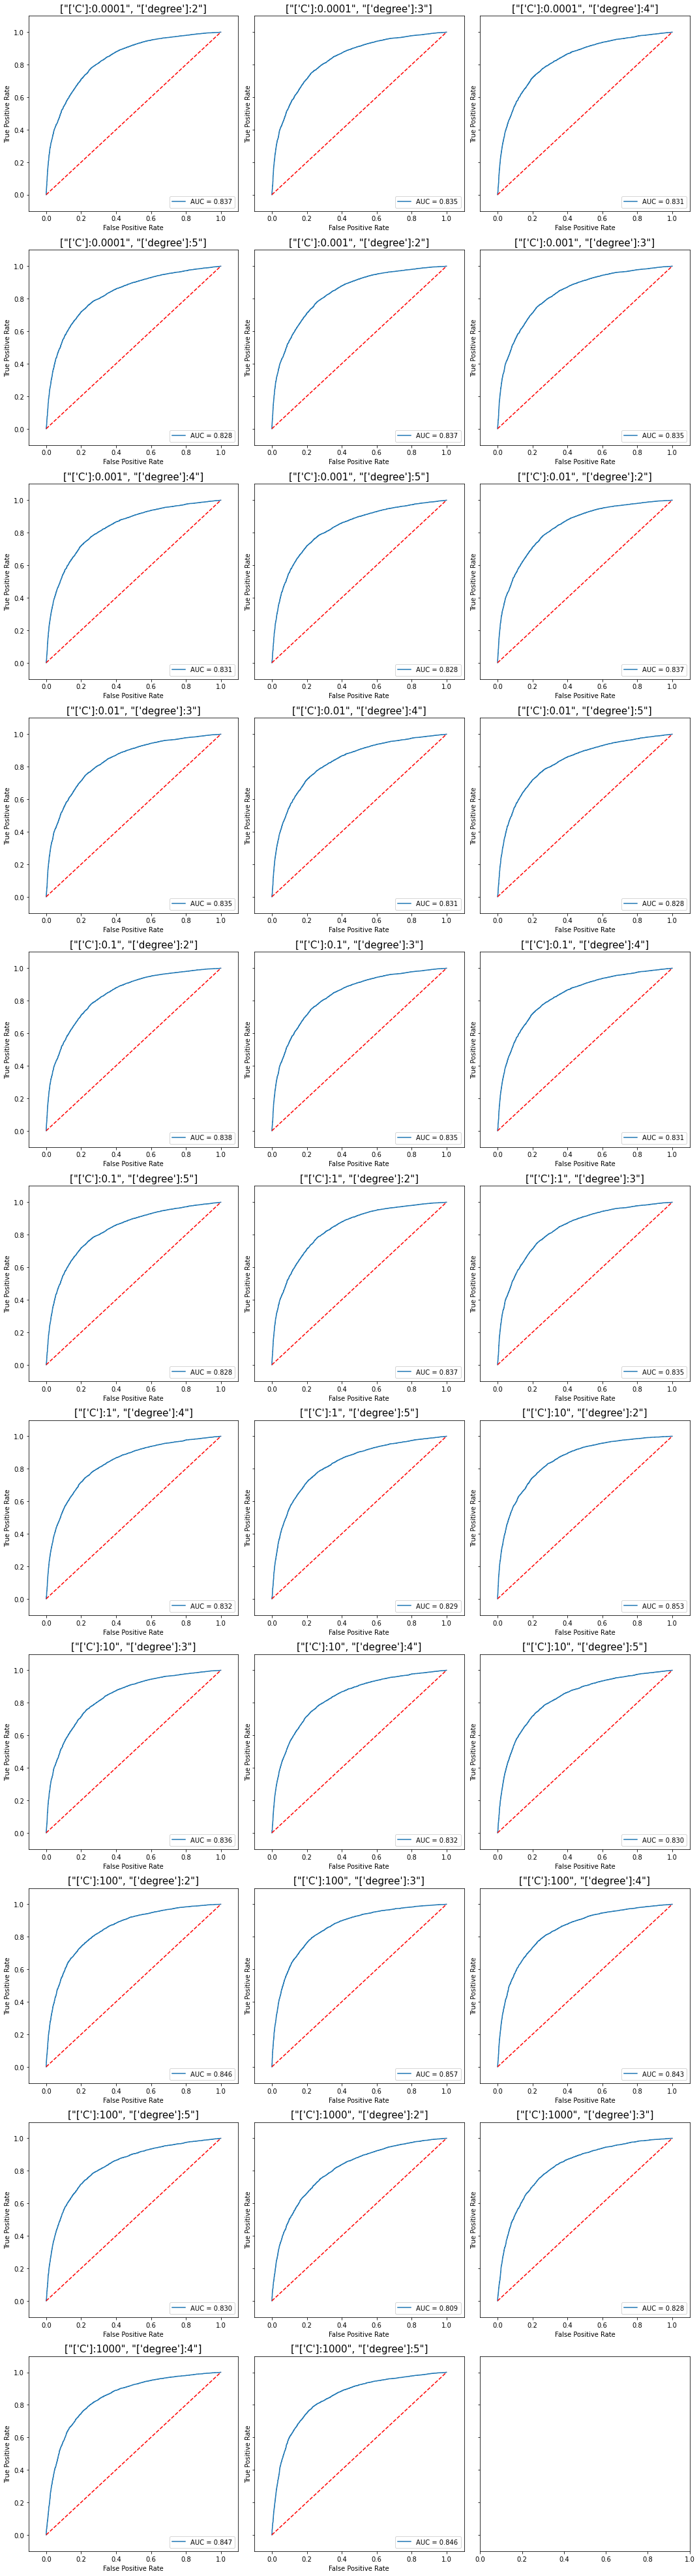

CPU times: user 31.2 s, sys: 209 ms, total: 31.4 s
Wall time: 31.4 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid4)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid4)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)
    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    # don't print the whole name or it won't fit
    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    print('For parameters', g ,' sensibility is: ',sen)

plt.gcf().tight_layout()
plt.show()

## RBF

In [0]:
param_grid6 = [
    {
        'clf__kernel': ['rbf'],
        'clf__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__gamma':['auto']
    }
]

For parameters {'clf__C': 0.0001, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.0
For parameters {'clf__C': 0.001, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.0
For parameters {'clf__C': 0.01, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.0
For parameters {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.0
For parameters {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.5649088856636026
For parameters {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.6644089662957587
For parameters {'clf__C': 100, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.674246089340429
For parameters {'clf__C': 1000, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}  sensibility is:  0.697468150298339


<Figure size 432x288 with 0 Axes>

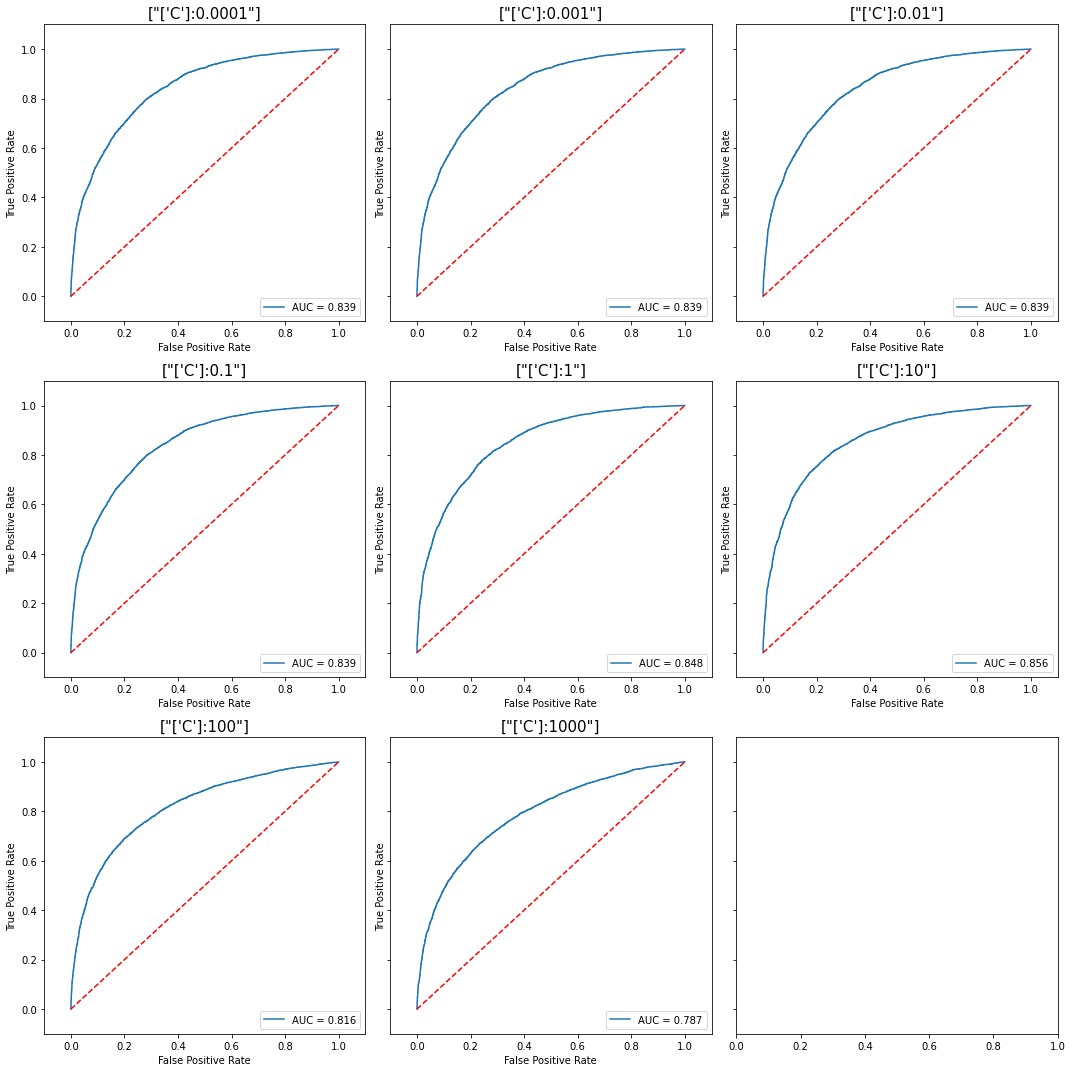

CPU times: user 8.85 s, sys: 120 ms, total: 8.97 s
Wall time: 8.86 s


In [0]:
%%time
num_cols = 3
num_rows = math.ceil(len(ParameterGrid(param_grid6)) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(ParameterGrid(param_grid6)):

    pipeline.set_params(**g)
    pipeline.fit(x_train_sub,y_train_sub)

    y_preds = pipeline.decision_function(x_test_sub)
    y_pred = pipeline.predict(x_test_sub)

    
    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = metrics.roc_curve(y_test_sub, y_preds)

    auc_score = metrics.auc(fpr, tpr)
    sen=metrics.recall_score(y_test_sub, y_pred)


    ax = axes[i // num_cols, i % num_cols]

    ax.set_title(str([r"{}:{}".format(
        k.split('__')[1:],v) for k,v in g.items() if "gamma" not in k and "kernel" not in k]),fontsize=15)
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    ax.plot([0,1],[0,1],'r--')

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    print('For parameters', g ,' sensibility is: ',sen)


plt.gcf().tight_layout()
plt.show()

## Parametros libres

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train_sub, y_train_sub)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_sub, clf.predict(x_test_sub)
    print(classification_report(y_true, y_pred))
    print()


## Comparison SVM

# Comparison

In [0]:
from tabulate import tabulate

Resultados: Normalmente mejor con oversampling 

#### 1. Oversampling

In [0]:
#rasultados validación
resultados = [['  ', 'LDA','Mayoria de votos','Boosted Trees','Random Forest'],
         ['Auc', auc_fo, auc_mo, auc_bo, auc_ro],
         ['Sensibilidad', sen_fo, sen_mo, sen_bo, sen_ro]]
print(tabulate(resultados, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════╤══════════╤════════════════════╤═════════════════╤═════════════════╕
│              │      LDA │   Mayoria de votos │   Boosted Trees │   Random Forest │
╞══════════════╪══════════╪════════════════════╪═════════════════╪═════════════════╡
│ Auc          │ 0.876094 │           0.885831 │        0.885402 │        0.878895 │
├──────────────┼──────────┼────────────────────┼─────────────────┼─────────────────┤
│ Sensibilidad │ 0.770194 │           0.594239 │        0.78397  │        0.282405 │
╘══════════════╧══════════╧════════════════════╧═════════════════╧═════════════════╛


#### 2. Undersampling

In [0]:
resultados = [['  ', 'LDA','Mayoria de votos','Boosted Trees','Random Forest'],
         ['Auc', auc_fu, auc_mu, auc_bu, auc_ru],
         ['Sensibilidad', sen_fu, sen_mu, sen_bu, sen_ru]]
print(tabulate(resultados, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════╤══════════╤════════════════════╤═════════════════╤═════════════════╕
│              │      LDA │   Mayoria de votos │   Boosted Trees │   Random Forest │
╞══════════════╪══════════╪════════════════════╪═════════════════╪═════════════════╡
│ Auc          │ 0.874167 │           0.885147 │        0.884013 │        0.881242 │
├──────────────┼──────────┼────────────────────┼─────────────────┼─────────────────┤
│ Sensibilidad │ 0.764559 │           0.807138 │        0.795867 │        0.804634 │
╘══════════════╧══════════╧════════════════════╧═════════════════╧═════════════════╛


#### 3. Unbalanced

In [0]:
resultados = [['  ', 'LDA','Mayoria de votos','Boosted Trees','Random Forest'],
         ['Auc', auc_f, auc_m, auc_b, auc_r],
         ['Sensibilidad', sen_f, sen_m, sen_b, sen_r]]
print(tabulate(resultados, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════╤══════════╤════════════════════╤═════════════════╤═════════════════╕
│              │      LDA │   Mayoria de votos │   Boosted Trees │   Random Forest │
╞══════════════╪══════════╪════════════════════╪═════════════════╪═════════════════╡
│ Auc          │ 0.866805 │           0.88555  │        0.883574 │        0.877681 │
├──────────────┼──────────┼────────────────────┼─────────────────┼─────────────────┤
│ Sensibilidad │ 0.406387 │           0.303694 │        0.313713 │        0.267376 │
╘══════════════╧══════════╧════════════════════╧═════════════════╧═════════════════╛
